<a href="https://colab.research.google.com/github/andreamust/HMSP-Graph/blob/master/google_colab_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM**

In [2]:
import json
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATASET_PATH = "drive/My Drive/mfccs_4.json"
classes = ['Q1', 'Q2', 'Q3', 'Q4']


def load_data(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)

        # convert lists into numpy arrays
        X = np.array(data["mfcc"])
        y = np.array(data["labels"])

        return X, y


def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=40)
    plt.xlabel('Predicted label', fontsize=40)
    plt.tight_layout()


def prepare_dataset(test_size, validation_size):
    # load data
    X, y = load_data(DATASET_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    # RNN . LSTM model
    # create model
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))  # True = s2s, False = s2v
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.LSTM(64, return_sequences=True))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.LSTM(32, return_sequences=False))
    model.add(keras.layers.Dropout(0.4))

    # dense layer
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.4))

    # output
    model.add(keras.layers.Dense(4, activation="softmax"))

    return model


def confusion(model, X, y):
    # X = X[np.newaxis, ...]
    prediction = model.predict(X)

    # extract index with the max value
    predicted_index = np.argmax(prediction, axis=1)

    predicted = predicted_index
    actual = y

    return actual, predicted


def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)

    # extract index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    # predicted_class = classes[predicted_index]
    # actual_class = classes[y]

    print("The expected index is {}\nThe predicted index is {}".format(y, predicted_index))


if __name__ == "__main__":
    # create train, validation and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(0.25, 0.2)

    # build the CNN net
    input_shape = (X_train.shape[1], X_train.shape[2])  # could be train, validation, test
    model = build_model(input_shape)

    # compile the net
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # train the CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=70)

    # evaluate the CNN on the testset
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy on testset is: {}".format(test_accuracy))

    # stop the training if the validation score doesn't increase

    # make a prediction on a sample
    X = X_validation[10]
    y = y_validation[10]
    predict(model, X, y)

    # make a prediction on a sample
    X = X_test[100]
    y = y_test[100]
    predict(model, X, y)

    # plot model summary
    model.summary()

    # plot accuracy and error over epochs
    plot_history(history)
    # Compute confusion matrix

    actual, predicted = confusion(model, X_validation, y_validation)

    cnf_matrix = confusion_matrix(actual, predicted)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(32, 24), dpi=200)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                          title='Confusion matrix, without normalization')
    plt.show()

Epoch 1/70
163/163 [==============================] - 29s 179ms/step - loss: 1.1647 - accuracy: 0.4481 - val_loss: 1.0309 - val_accuracy: 0.5412
Epoch 2/70
163/163 [==============================] - 28s 172ms/step - loss: 1.0702 - accuracy: 0.5067 - val_loss: 1.0305 - val_accuracy: 0.5482
Epoch 3/70
163/163 [==============================] - 28s 172ms/step - loss: 1.0466 - accuracy: 0.5212 - val_loss: 0.9876 - val_accuracy: 0.5536
Epoch 4/70
163/163 [==============================] - 28s 172ms/step - loss: 1.0237 - accuracy: 0.5372 - val_loss: 1.0322 - val_accuracy: 0.5420
Epoch 5/70
163/163 [==============================] - 28s 172ms/step - loss: 1.0143 - accuracy: 0.5449 - val_loss: 1.0624 - val_accuracy: 0.4803
Epoch 6/70
163/163 [==============================] - 28s 172ms/step - loss: 1.0235 - accuracy: 0.5359 - val_loss: 0.9737 - val_accuracy: 0.5482
Epoch 7/70
163/163 [==============================] - 28s 173ms/step - loss: 1.0032 - accuracy: 0.5550 - val_loss: 0.9955 - val_ac

KeyboardInterrupt: ignored

# **CNN**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 10, 128)      2176      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 5, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 5, 128)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 5, 128)        512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 3, 64)         73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 2, 64)         0

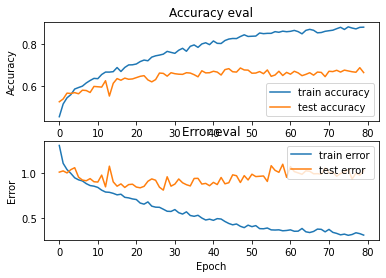

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATASET_PATH = "drive/My Drive/mfccs_5.json"
classes = ['Q1', 'Q2', 'Q3', 'Q4']


def load_data(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)

        # convert lists into numpy arrays
        X = np.array(data["mfcc"])
        y = np.array(data["labels"])

        return X, y


def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def prepare_dataset(test_size, validation_size):
    # load data
    X, y = load_data(DATASET_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # 3D array for each sample (what tensorflow expects for CNNs)
    X_train = X_train[..., np.newaxis]  # 4D array -> (num_samples, 130, 3, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):

    # create model
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(128, (4, 4), activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding="same"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding="same"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (2, 2), activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding="same"))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.BatchNormalization())



    # flatten the output
    model.add(keras.layers.Flatten())

    # feed a dense network

    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))

    # output
    model.add(keras.layers.Dense(4, activation="softmax"))

    return model


def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)

    # extract index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    print("The expected index is {}\nThe predicted index is {}".format(y, predicted_index))


if __name__ == "__main__":

    # create train, validation and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(test_size=0.25, validation_size=0.2)

    # build the CNN net
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])  # could be train, validation, test
    model = build_model(input_shape)

    model.summary()

    # compile the net
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # save the model
    model.save('CNN.model')


    # train the CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=80)

    # evaluate the CNN on the testset
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy on testset is: {}".format(test_accuracy))

    # make a prediction on a sample
    X = X_test[100]
    y = y_test[100]
    predict(model, X, y)

    # plot accuracy and error over epochs
    plot_history(history)


# **CNN + LSTM**

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_71 (Batc (None, 128, 13, 1)        4         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 128, 13, 64)       320       
_________________________________________________________________
activation_49 (Activation)   (None, 128, 13, 64)       0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 128, 13, 64)       256       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 64, 6, 64)         0         
_________________________________________________________________
dropout_95 (Dropout)         (None, 64, 6, 64)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 6, 128)      

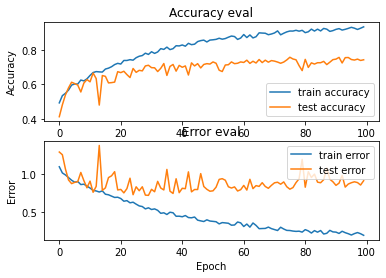

Confusion matrix, without normalization
[[232  52  11  18]
 [ 14 286   9   4]
 [ 23  16 210  74]
 [ 28  17  69 234]]


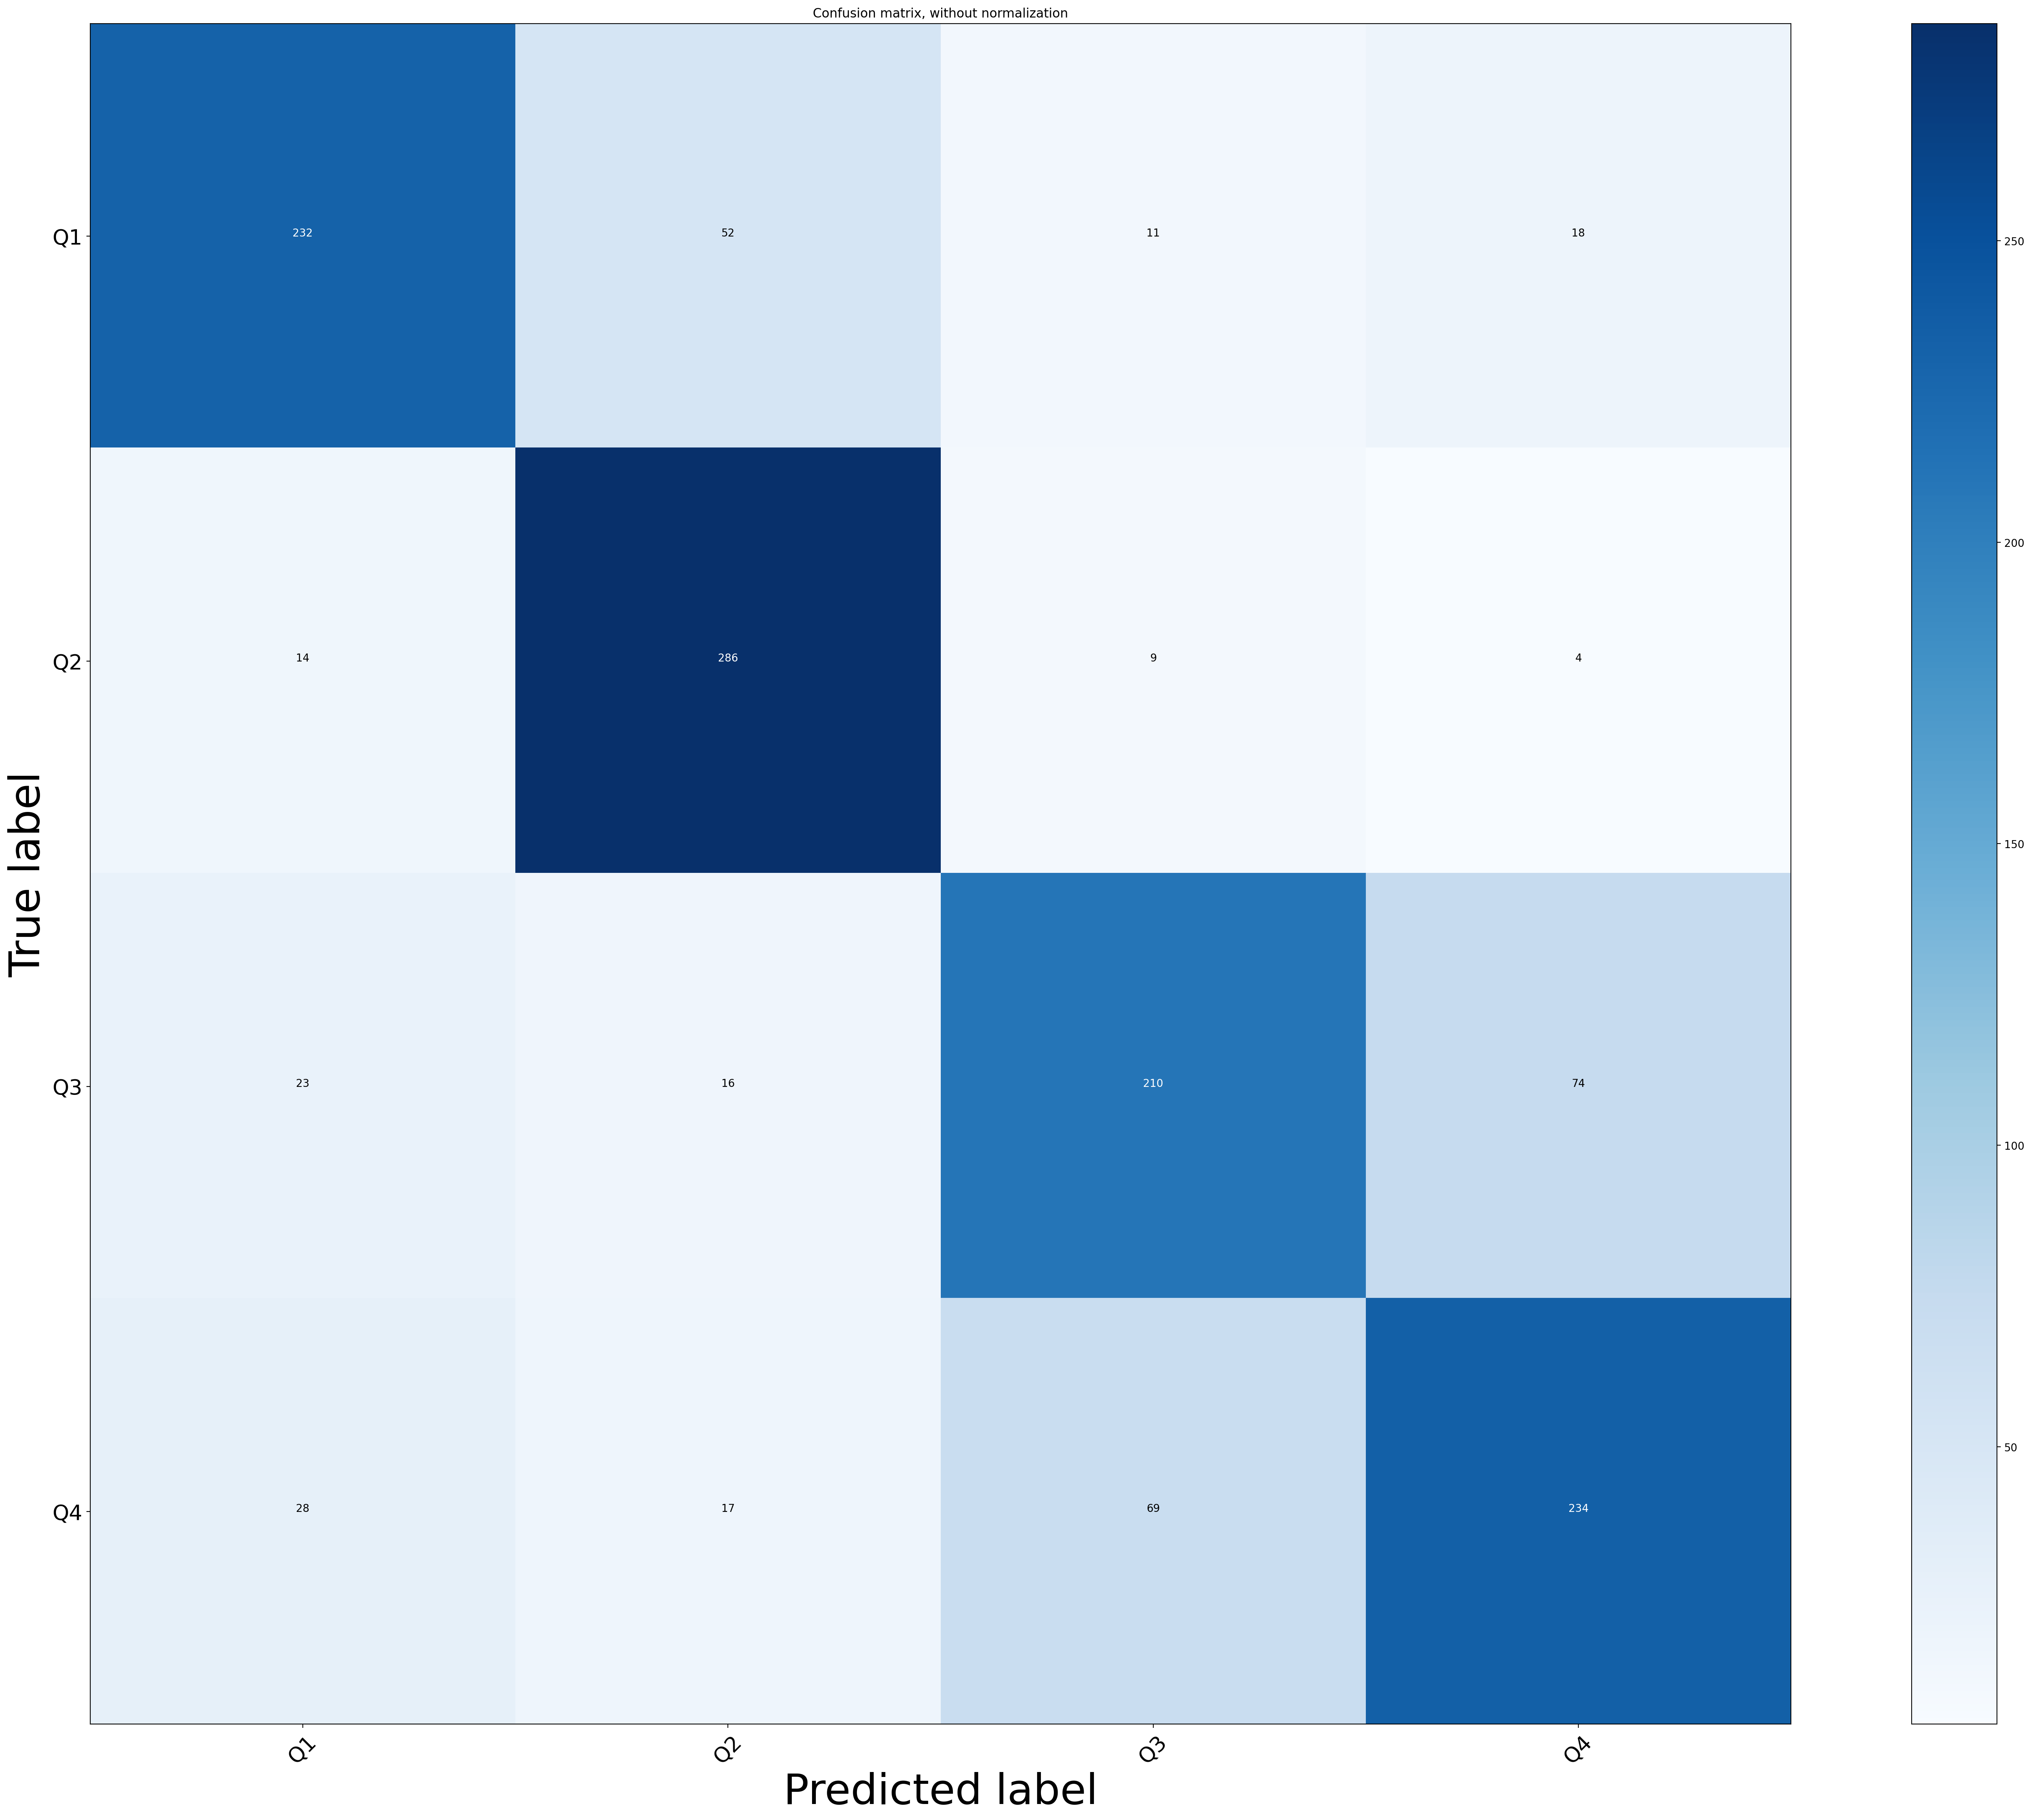

In [23]:
import json
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATASET_PATH = "drive/My Drive/mfccs_5.json"
classes = ['Q1', 'Q2', 'Q3', 'Q4']


def load_data(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)

        # convert lists into numpy arrays
        X = np.array(data["mfcc"])
        y = np.array(data["labels"])

        return X, y

def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, fontsize=20, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=40)
    plt.xlabel('Predicted label', fontsize=40)
    plt.tight_layout()

def prepare_dataset(test_size, validation_size):
    # load data
    X, y = load_data(DATASET_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # 3D array for each sample (what tensorflow expects for CNNs)
    X_train = X_train[..., np.newaxis]  # 4D array -> (num_samples, 130, 3, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    # RNN . LSTM model
    nb_layers = 3  # number of convolutional layers
    nb_filters = [64, 128, 128, 128]  # filter sizes
    kernel_size = (2, 2)  # convolution kernel size
    activation = 'relu'  # activation function to use after each layer
    pool_size = [(2, 2), (4, 2), (4, 2), (4, 2),
                 (4, 2)]  # size of pooling area
    
    frequency_axis = 2
    time_axis = 1
    channel_axis = 3

    # create model
    model = keras.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=input_shape))

    # layers
    model.add(keras.layers.Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape))  # True = s2s, False = s2v
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size[0], strides=pool_size[0]))
    model.add(keras.layers.Dropout(0.2))

    for layer in range(nb_layers - 1):
      # Convolutional layer
      model.add(keras.layers.Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                      padding='same'))
      model.add(keras.layers.Activation(activation))
      model.add(keras.layers.BatchNormalization())  # Improves overfitting/underfitting
      model.add(keras.layers.MaxPooling2D(pool_size=pool_size[layer + 1],
                            strides=pool_size[layer + 1]))  # Max pooling
      model.add(keras.layers.Dropout(0.2))

    # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    model.add(keras.layers.Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(keras.layers.Reshape((model.output_shape[1], resize_shape)))

    # recurrent layer
    model.add(keras.layers.GRU(128, return_sequences=True))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.GRU(64, return_sequences=True))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.GRU(32, return_sequences=False))
    model.add(keras.layers.Dropout(0.3))

    # output
    model.add(keras.layers.Dense(4, activation="softmax"))

    return model

def confusion(model, X, y):
    # X = X[np.newaxis, ...]
    prediction = model.predict(X)

    # extract index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    
    predicted = predicted_index
    actual = y

    return actual, predicted

def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)

    # extract index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    # predicted_class = classes[predicted_index]
    # actual_class = classes[y]

    print("The expected index is {}\nThe predicted index is {}".format(y, predicted_index))


if __name__ == "__main__":

    # create train, validation and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(0.25, 0.2)
    
    # build the CNN net
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])  # could be train, validation, test
    model = build_model(input_shape)
    
    model.summary()
    # compile the net
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # train the CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)


    # evaluate the CNN on the testset
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy on testset is: {}".format(test_accuracy))

    # save the model
    model.save('CNN+LSTM.model')



    # make a prediction on a sample
    X = X_validation[10]
    y = y_validation[10]
    predict(model, X, y)

    # make a prediction on a sample
    X = X_test[100]
    y = y_test[100]
    predict(model, X, y)

    # plot accuracy and error over epochs
    plot_history(history)

    # Compute confusion matrix
    
    actual, predicted = confusion(model, X_validation, y_validation)

    cnf_matrix = confusion_matrix(actual, predicted)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(32, 24), dpi=200)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                          title='Confusion matrix, without normalization')
    plt.show()